<a href="https://colab.research.google.com/github/HenryLau08/adsai-mlops-2025/blob/main/MLOPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLOPs Portfolio


|Naam|studentnummer|Github|
|----|-------------|------|
|Henry Lau|22122958|HenryLau08|
||||
||||
||||

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %pip install kaggle

In [ ]:
# %pip install ultralytics

In [ ]:
# %pip install mlflow

In [ ]:
# %pip install opencv-python

In [ ]:
# imports
import os
from pathlib import Path
import cv2
import shutil
import zipfile
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
import yaml
from ultralytics import YOLO
import mlflow

# run it once (for colab)
# os.makedirs("/root/.config/kaggle/", exist_ok=True)
# shutil.move("kaggle.json", "/root/.config/kaggle/") # manually upload your kaggle.json file and run it once
# !chmod 600 /root/.config/kaggle/kaggle.json
# import kaggle

In [ ]:
base_dir = Path("/content/drive/MyDrive/Colab Notebooks/data") # use this if you are working on colab
# base_dir = Path(".") # use this if you are working on VSCode
base_dir.mkdir(parents=True, exist_ok=True)

https://www.kaggle.com/datasets/sakshamjn/vehicle-detection-8-classes-object-detection

In [ ]:
kaggle_path = base_dir / 'kaggle'
os.makedirs(kaggle_path, exist_ok=True)

# kaggle.api.dataset_download_files("sakshamjn/vehicle-detection-8-classes-object-detection", path=kaggle_path, unzip=True)

## 4.1 Train-Test Split

### Yolo Nano

Binnen YOLO zijn er varianten met de letter “n” in de modelnaam, zoals YOLOv10n, YOLO11n en YOLO12n. De “n” staat hierbij voor Nano en duidt aan dat het gaat om de kleinste en meest efficiënte versies van elk model.

YOLO Nano-modellen zijn speciaal ontworpen voor situaties waarin weinig rekenkracht beschikbaar is. Ondanks hun compacte formaat kunnen deze modellen verrassend goede prestaties leveren in toepassingen zoals detectie, classificatie en segmentatie. Deze optimalisatie is nodig voor real-time toepassingen op energiezuinige of draagbare apparaten, bijvoorbeeld op edge devices zoals de NVIDIA Jetson Nano [(Kim, 2024)](https://medium.com/@elvenkim1/yolov8-nano-vs-yolov8-large-4f21324baa38).

Volgens Ultralytics, is het best om zelf meerdere modellen te testen, want de scores kunnen variëren door het trainen op eigen datasets. Daarom kiezen we om de latest models (yolov10, yolo11 en yolo12) te testen [(Ultralytics, 2025a)](https://youtu.be/mcqTxD-FD5M?t=118).


- Ultralytics. (2025a, februari 21). How to Use YOLO12 for Object Detection with the Ultralytics Package | Is YOLO12 Fast or Slow? 🚀 [Video]. YouTube. https://www.youtube.com/watch?v=mcqTxD-FD5M
- Kim, E. (2024, 18 november). YOLOv8 Nano vs YOLOv8 large - Elven Kim - Medium. Medium. https://medium.com/@elvenkim1/yolov8-nano-vs-yolov8-large-4f21324baa38

```
working/dataset/
├── big_model/
│   ├── images/
│   │   ├── train/           ← training images
│   │   └── val/             ← validation images
│   ├── labels/
│   │   ├── train/           ← labels for training images
│   │   └── val/             ← labels for validation images
│   └── vehicles_full.yaml   ← data.yaml for big model

├── small_model/
│   ├── images/
│   │   ├── train/           ← training images (same as big_model)
│   │   └── val/             ← validation images (same as big_model)
│   ├── labels/
│   │   ├── train/           ← generic "vehicle" labels
│   │   └── val/
│   └── vehicles_general.yaml ← data.yaml for small model
```

In [ ]:
data_dir = base_dir / 'working/dataset'

In [ ]:
data_yaml = {
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,
    'names': ['vehicle']
}

small_model_path = data_dir / 'small_model'

with open(small_model_path / 'vehicles_general.yaml', 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

In [ ]:
project_path = base_dir / 'runs'
os.makedirs(project_path, exist_ok=True)

We slaan de resultaten en modellen op in onze Google Drive, zodat we ze later opnieuw kunnen gebruiken zonder het hele proces opnieuw uit te voeren. Vanuit Google Drive kunnen we de modellen eenvoudig laden en ermee verder werken.

In [ ]:
# Laad een YOLO model
model = YOLO('yolo12n.pt')

# Definieer het pad naar je data.yaml bestand
data_yaml_path = small_model_path / 'vehicles_general.yaml'

# Train het model
results = model.train(data=data_yaml_path, epochs=100, plots=True, save=True, name='yolo12n', project=project_path)

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/vehicles_general.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

train: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/train.cache... 6574 images, 11 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2611_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2651_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2690_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2695_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2696_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2751_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2784_2020-08

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.4±0.9 ms, read: 13.4±8.2 MB/s, size: 66.1 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/val.cache... 1644 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2517_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2682_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2744_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2771_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2908_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3001_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3289_2020-08-26.jpg: 1 duplicate labels 

Plotting labels to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)


2025/06/13 13:44:27 INFO mlflow.tracking.fluent: Experiment with name '/content/drive/MyDrive/Colab Notebooks/data/runs' does not exist. Creating a new experiment.
2025/06/13 13:44:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/06/13 13:44:28 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/06/13 13:44:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(7ee3237d113d43d78ea59efaff9ef88f) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.24G      1.511       1.46      1.185         38        640: 100%|██████████| 411/411 [02:35<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:20<00:00,  2.48it/s]


                   all       1644       5243      0.781      0.792      0.854      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.66G      1.477      0.972      1.207         35        640: 100%|██████████| 411/411 [02:27<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]


                   all       1644       5243      0.819      0.825      0.882      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.67G      1.447     0.8703      1.189         31        640: 100%|██████████| 411/411 [02:26<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]


                   all       1644       5243      0.819      0.818      0.876      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.68G      1.412     0.8141      1.172         38        640: 100%|██████████| 411/411 [02:25<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]


                   all       1644       5243      0.851      0.845      0.913      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.68G      1.375     0.7633      1.156         40        640: 100%|██████████| 411/411 [02:25<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]


                   all       1644       5243      0.866      0.866      0.926      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.68G      1.346     0.7329      1.144         42        640: 100%|██████████| 411/411 [02:23<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.84it/s]


                   all       1644       5243      0.866      0.866      0.927      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.68G      1.311     0.6909      1.128         41        640: 100%|██████████| 411/411 [02:23<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]

                   all       1644       5243      0.862      0.875      0.929      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.68G      1.283     0.6627      1.114         38        640: 100%|██████████| 411/411 [02:25<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]


                   all       1644       5243      0.864      0.875      0.934       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.68G      1.251     0.6373      1.099         36        640: 100%|██████████| 411/411 [02:24<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.79it/s]

                   all       1644       5243      0.871      0.882      0.941      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.68G       1.23     0.6128       1.09         39        640: 100%|██████████| 411/411 [02:25<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.93it/s]


                   all       1644       5243      0.866      0.881      0.941      0.624

10 epochs completed in 0.460 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:21<00:00,  2.42it/s]


                   all       1644       5243      0.866      0.881      0.941      0.624
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo12n
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [ ]:
# Laad een YOLO model
model = YOLO('yolo11n.pt')

# Train het model
results = model.train(data=data_yaml_path, epochs=100, plots=True, save=True, imgsz=480, project=project_path, name='yolo11n')

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/vehicles_general.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

train: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/train.cache... 6574 images, 11 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2611_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2651_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2690_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2695_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2696_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2751_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2784_2020-08

val: Fast image access ✅ (ping: 2.5±2.8 ms, read: 7.1±1.6 MB/s, size: 66.1 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/val.cache... 1644 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2517_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2682_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2744_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2771_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2908_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3001_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3289_2020-08-26.jpg: 1 duplicate labels 

Plotting labels to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/06/13 14:14:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/06/13 14:14:08 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/06/13 14:14:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(b10d009009f345e9bc5a6ab1d1030e98) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.36G      1.495      1.377      1.106         38        480: 100%|██████████| 411/411 [01:47<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:15<00:00,  3.46it/s]


                   all       1644       5243      0.796      0.829      0.877      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.62G      1.453     0.9209      1.106         35        480: 100%|██████████| 411/411 [01:44<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.53it/s]


                   all       1644       5243      0.815      0.819      0.875      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.62G      1.435     0.8392      1.109         31        480: 100%|██████████| 411/411 [01:41<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.58it/s]


                   all       1644       5243      0.834      0.861      0.897      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.62G      1.395     0.7796      1.089         38        480: 100%|██████████| 411/411 [01:40<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.61it/s]


                   all       1644       5243      0.832      0.848      0.904      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.62G       1.36     0.7436      1.075         40        480: 100%|██████████| 411/411 [01:41<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.52it/s]


                   all       1644       5243      0.836      0.862      0.917      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.62G      1.327     0.7105      1.062         42        480: 100%|██████████| 411/411 [01:41<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.49it/s]

                   all       1644       5243      0.872      0.854      0.924      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.62G      1.297     0.6759      1.052         41        480: 100%|██████████| 411/411 [01:40<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.57it/s]

                   all       1644       5243       0.86      0.866      0.927      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.62G      1.266     0.6509      1.039         38        480: 100%|██████████| 411/411 [01:40<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:14<00:00,  3.51it/s]

                   all       1644       5243      0.882      0.871      0.937       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.62G      1.241     0.6277      1.032         36        480: 100%|██████████| 411/411 [01:39<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.74it/s]


                   all       1644       5243      0.873      0.886       0.94      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.62G      1.213     0.6033      1.018         39        480: 100%|██████████| 411/411 [01:52<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]

                   all       1644       5243      0.872      0.879      0.943      0.622



10 epochs completed in 0.331 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/weights/last.pt, 5.4MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/weights/best.pt, 5.4MB

Validating /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:16<00:00,  3.20it/s]


                   all       1644       5243      0.872       0.88      0.944      0.622
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/drive/MyDrive/Colab Notebooks/data/runs/yolo11n
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [ ]:
# Laad een YOLO model
model = YOLO('yolov10n.pt')

# Train het model
results = model.train(data=data_yaml_path, epochs=100, plots=True, save=True, project=project_path, name='yolo10n')

100%|██████████| 5.59M/5.59M [00:00<00:00, 91.6MB/s]


Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/vehicles_general.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

YOLOv10n summary: 223 layers, 2,707,430 parameters, 2,707,414 gradients, 8.4 GFLOPs

Transferred 493/595 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.1±0.0 MB/s, size: 29.0 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/train.cache... 6574 images, 14 backgrounds, 0 corrupt: 100%|██████████| 6574/6574 [00:00<?, ?it/s]

train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2651_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2682_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2690_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2696_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2744_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2751_2020-08-26.jpg: 1 duplicate labels removed
train: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/train/highway_2771_2020-08

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.2±0.2 MB/s, size: 66.6 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/labels/val.cache... 1644 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1644/1644 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2517_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2611_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_2695_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3432_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3599_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/highway_3745_2020-08-26.jpg: 1 duplicate labels removed
val: /content/drive/MyDrive/Colab Notebooks/data/working/dataset/small_model/images/val/ulu1035_jpg.rf.e281567375e34e6eb8c273fbd14f7836.

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)


2025/06/12 19:34:43 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2025/06/12 19:34:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/12 19:34:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/12 19:34:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/06/12 19:34:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/06/12 19:34:49 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/06/12 19:34:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(f9e5a2a7e4e14abaa6636c4adb9d2764) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.74G      3.019       4.65      2.322         30        640: 100%|██████████| 411/411 [36:09<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]


                   all       1644       5290      0.705      0.709      0.751      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.23G      3.037      2.258      2.365         34        640: 100%|██████████| 411/411 [02:21<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.06it/s]

                   all       1644       5290      0.724      0.738      0.793      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.23G      2.981      1.826      2.357         32        640: 100%|██████████| 411/411 [02:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]

                   all       1644       5290      0.787      0.758      0.842       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.25G      2.897      1.653      2.319         50        640: 100%|██████████| 411/411 [02:18<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]


                   all       1644       5290      0.801      0.814      0.871      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.26G      2.847      1.539      2.284         45        640: 100%|██████████| 411/411 [02:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.05it/s]

                   all       1644       5290      0.821      0.818      0.884      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.26G      2.757       1.45      2.244         31        640: 100%|██████████| 411/411 [02:20<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:16<00:00,  3.07it/s]

                   all       1644       5290      0.819      0.832      0.889      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.28G      2.696      1.376      2.214         40        640: 100%|██████████| 411/411 [02:21<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  2.98it/s]

                   all       1644       5290      0.827       0.84      0.901      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.28G      2.632      1.321      2.193         43        640: 100%|██████████| 411/411 [02:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:16<00:00,  3.08it/s]


                   all       1644       5290      0.855      0.845      0.913      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.28G      2.581       1.27      2.169         47        640: 100%|██████████| 411/411 [02:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:17<00:00,  3.01it/s]


                   all       1644       5290      0.857      0.848      0.919      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.28G      2.514      1.207      2.144         39        640: 100%|██████████| 411/411 [02:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.81it/s]

                   all       1644       5290      0.872      0.858      0.926       0.61



10 epochs completed in 1.007 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,363 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]


                   all       1644       5290      0.873      0.858      0.926       0.61
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


## 4.4 Model Evalueren

Kijken naar de resultaten uit de validation set.

In [ ]:
def plot_yolo_results(folder_name, base_path='/runs', include='val_batch'):
    """
    Zoekt en plot specifieke afbeeldingen (jpg/png) uit een YOLO-resultatenfolder.

    Parameters:
    - folder_name (str): Naam van de YOLO-subfolder (bijv. 'detect/train1').
    - base_path (str): Basispad waar de YOLO-runs worden opgeslagen (standaard: '/runs').
    - include (str or list of str): Filter om alleen specifieke afbeeldingen te plotten 
      (bijv. 'val_batch' of ['val_batch', 'confusion_matrix']).
    """
    full_path = os.path.join(base_path, folder_name)

    if not os.path.exists(full_path):
        print(f"Folder '{full_path}' bestaat niet.")
        return

    # Normaliseer include naar een lijst
    if isinstance(include, str):
        include = [include]

    # Zoek afbeeldingen die voldoen aan de filter en extensie
    image_files = [
        f for f in os.listdir(full_path)
        if f.lower().endswith(('.jpg', '.png')) and any(key in f for key in include)
    ]

    if not image_files:
        print(f"Geen afbeeldingen gevonden in '{full_path}' met filter {include}.")
        return

    # Sorteer op naam
    image_files.sort()

    # Plot de gevonden afbeeldingen
    for img_file in image_files:
        img_path = os.path.join(full_path, img_file)
        try:
            img = Image.open(img_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(img_file)
            plt.show()
        except Exception as e:
            print(f"Kon afbeelding '{img_file}' niet openen: {e}")

We zoeken nieuwe data op (video of foto) en kijken wat de resultaat wordt.

In [ ]:
eval_path = base_dir / 'evaluation'
model_name = 'yolo12n'
model = YOLO(project_path / f'detect/{model_name}/weights/best.pt')

results = model('', save=True, name=model_name, project=eval_path, imgsz=640)


0: 640x640 2 cars, 2 motorcycles, 31.1ms
1: 640x640 4 cars, 31.1ms
Speed: 7.7ms preprocess, 31.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
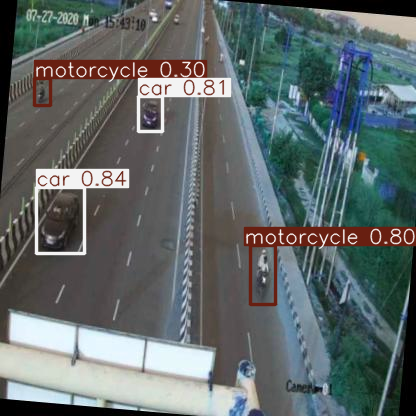

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
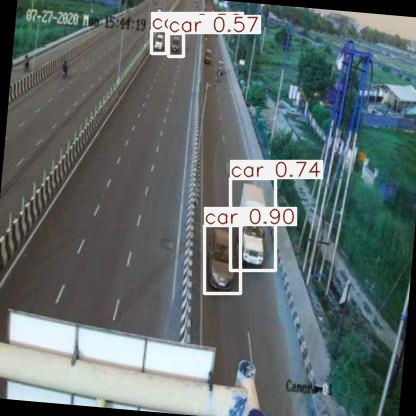

In [ ]:
# Laad het getrainde model (of gebruik het modelobject van de training)
model = YOLO('/content/runs/detect/train3/weights/best.pt') # Pas dit pad aan naar waar je model is opgeslagen

# Definieer de paden naar de afbeeldingen die je wilt gebruiken voor predictie
# Je kunt hier een lijst van afbeeldingspaden opgeven, bijvoorbeeld uit je testset
predict_images = [
    '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/images/Highway_1000_2020-07-30_jpg.rf.e9364fb1c7d1bf9f8cbea3d1c1575050.jpg',
    '/content/drive/MyDrive/Colab Notebooks/data/working/dataset/test/images/Highway_1006_2020-07-30_jpg.rf.c58b7b2098d969e925b271bcd436ac25.jpg',
    # Voeg hier meer afbeeldingspaden toe
] # Pas deze paden aan

# Voer predicties uit
results = model.predict(predict_images)

# Toon de resultaten
for result in results:
    display(result.plot()) # result.plot() tekent de bounding boxes op de afbeelding

# 5. Deployment

Beschrijf hoe het model wordt gedeployed op edge-apparaten en in de cloud.

In deze sectie beschrijf je hoe je het model deployt op edge-apparaten en in de cloud. Gebruik markdown-cellen om de deploymentstrategie te beschrijven.

Edge Deployment

Beschrijf hoe je het model implementeert op edge-apparaten zoals slimme camera's of embedded systemen.

Leg uit hoe je ervoor zorgt dat het model realtime voertuigdetectie kan uitvoeren.

Cloud Deployment

Beschrijf hoe je het geavanceerde deep learning-model in de cloud deployt voor voertuigclassificatie.



## 5.1 Edge Deployment

## 5.2 Cloud Deployment

# 6. Monitoring en Feedback

Beschrijf hoe de prestaties van het model worden gemonitord en hoe het model wordt hertraind op basis van nieuwe data.

In deze sectie beschrijf je hoe je de prestaties van het model monitort en hoe je het model hertraind op basis van nieuwe data. Gebruik markdown-cellen om de monitoringstrategie te beschrijven.

Data Drift Detection

Beschrijf hoe je veranderingen in de inkomende data detecteert en hoe je hierop reageert.

Model Performance Monitoring

Beschrijf hoe je de nauwkeurigheid, recall en precision van het model continu monitort.

Leg uit hoe je automatisch logging van verkeerde voorspellingen implementeert.

Hertraining

Beschrijf hoe je het model periodiek hertraind op basis van nieuwe data en feedback.

7. Conclusie


## 6.1 Data Drift Detection

## 6.2 Hertraining

# 7. Conclusie

Geef een samenvatting van de datapijplijn en bespreek eventuele uitdagingen of verbeterpunten.

In deze sectie geef je een samenvatting van de datapijplijn en bespreek je eventuele uitdagingen of verbeterpunten. Gebruik markdown-cellen om de conclusie te schrijven.




# 8. Bronvermelding